<a href="https://colab.research.google.com/github/gemepolimi/gemepolimi/blob/main/SPI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
print("Installing required packages...")
print("="*80)

# Install openpyxl for Excel file reading (if not already installed)
!pip install openpyxl -q

print("\nImporting libraries...")
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Patch
import warnings
warnings.filterwarnings('ignore')

# For file upload in Colab
from google.colab import files
import io

print("✓ All libraries imported successfully!")
print("="*80)

Installing required packages...

Importing libraries...
✓ All libraries imported successfully!


In [ ]:
print("\n" + "="*80)
print("STEP 1: UPLOAD YOUR EXCEL FILE")
print("="*80)
print("\nPlease upload your Excel file (QC_Calculations_Addis_Ababa.xlsx)")
print("Click 'Choose Files' button below...\n")

# Upload file
uploaded = files.upload()

# Get the filename
filename = list(uploaded.keys())[0]
print(f"\n✓ File uploaded: {filename}")

# Read the Excel file
print("\nReading Excel file...")
df_raw = pd.read_excel(filename, sheet_name='1_Raw_Data')

print(f"✓ Loaded {df_raw.shape[0]} years of data")
print(f"  Columns: {list(df_raw.columns[:5])}...")
print(f"  Period: {df_raw['Year'].min()} to {df_raw['Year'].max()}")



STEP 1: UPLOAD YOUR EXCEL FILE

Please upload your Excel file (QC_Calculations_Addis_Ababa.xlsx)
Click 'Choose Files' button below...



Saving QC_Calculations_Addis_Ababa.xlsx to QC_Calculations_Addis_Ababa (1).xlsx

✓ File uploaded: QC_Calculations_Addis_Ababa (1).xlsx

Reading Excel file...
✓ Loaded 43 years of data
  Columns: ['Year', 'Jan', 'Feb', 'Mar', 'Apr']...
  Period: 1898 to 1940


In [ ]:
print("\n" + "="*80)
print("STEP 2: DATA PREPARATION")
print("="*80)

# Define month columns
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Convert to long format
print("\nConverting to long format...")
df_long = df_raw.melt(id_vars=['Year'], value_vars=months,
                      var_name='Month', value_name='Precipitation')

# Map month names to numbers
month_map = {month: i+1 for i, month in enumerate(months)}
df_long['MonthNum'] = df_long['Month'].map(month_map)

# Sort by year and month
df_long = df_long.sort_values(['Year', 'MonthNum']).reset_index(drop=True)

# Convert precipitation to numeric
df_long['Precipitation'] = pd.to_numeric(df_long['Precipitation'], errors='coerce')

# Create date column
df_long['Date'] = pd.to_datetime({
    'year': df_long['Year'],
    'month': df_long['MonthNum'],
    'day': 1
})

# Report on data quality
total_months = len(df_long)
missing_months = df_long['Precipitation'].isna().sum()
valid_months = total_months - missing_months

print(f"✓ Data prepared successfully")
print(f"  Total months: {total_months}")
print(f"  Valid observations: {valid_months} ({100*valid_months/total_months:.1f}%)")
print(f"  Missing observations: {missing_months} ({100*missing_months/total_months:.1f}%)")



STEP 2: DATA PREPARATION

Converting to long format...
✓ Data prepared successfully
  Total months: 516
  Valid observations: 499 (96.7%)
  Missing observations: 17 (3.3%)


In [ ]:
print("\n" + "="*80)
print("STEP 3: CALCULATING SPI")
print("="*80)

def calculate_spi(data_series, scale, month_nums):
    """
    Calculate SPI using Gamma distribution fitting by calendar month.

    Based on McKee et al. (1993) methodology.
    """
    # Calculate rolling sums
    rolling_precip = data_series.rolling(window=scale, min_periods=scale).sum()

    # Initialize SPI array
    spi = np.full(len(data_series), np.nan)

    # Fit distribution separately for each calendar month
    for month in range(1, 13):
        # Get all observations for this calendar month
        month_indices = np.where(month_nums == month)[0]
        month_data = rolling_precip.iloc[month_indices]

        # Get valid (non-NaN) values
        valid_indices = month_data.dropna().index
        valid_data = month_data.loc[valid_indices].values

        if len(valid_data) < 10:
            continue

        # Calculate probability of zero
        p_zero = (valid_data == 0).sum() / len(valid_data)

        # Fit Gamma distribution to non-zero values
        non_zero_data = valid_data[valid_data > 0]

        if len(non_zero_data) < 5:
            continue

        try:
            # Fit Gamma distribution (shape and scale, location=0)
            shape, loc, scale_param = stats.gamma.fit(non_zero_data, floc=0)

            # Calculate CDF for all valid observations
            cdf = np.zeros(len(valid_data))
            cdf[valid_data > 0] = stats.gamma.cdf(valid_data[valid_data > 0],
                                                   shape, loc, scale_param)

            # Adjust for zero probability: H(x) = q + (1-q)*G(x)
            h = p_zero + (1 - p_zero) * cdf

            # Clip to avoid extreme values
            h = np.clip(h, 0.0001, 0.9999)

            # Transform to standard normal distribution
            spi_values = stats.norm.ppf(h)

            # Store results
            spi[valid_indices] = spi_values

        except Exception as e:
            continue

    return spi


# Calculate SPI for all timescales
timescales = [1, 3, 6, 12]

print("\nCalculating SPI for each timescale...")
print("-"*80)

for scale in timescales:
    print(f"\nSPI-{scale}:")

    # Calculate rolling sums
    col_name = f'Precip_{scale}month'
    df_long[col_name] = df_long['Precipitation'].rolling(
        window=scale, min_periods=scale).sum()

    # Calculate SPI
    spi_col = f'SPI_{scale}'
    df_long[spi_col] = calculate_spi(df_long['Precipitation'], scale, df_long['MonthNum'])

    # Report statistics
    spi_data = df_long[spi_col].dropna()
    print(f"  Valid SPI values: {len(spi_data)}")
    print(f"  Mean: {spi_data.mean():.3f} (target: 0.000)")
    print(f"  Std Dev: {spi_data.std():.3f} (target: 1.000)")
    print(f"  Range: [{spi_data.min():.2f}, {spi_data.max():.2f}]")

print("\n✓ SPI calculation complete!")


STEP 3: CALCULATING SPI

Calculating SPI for each timescale...
--------------------------------------------------------------------------------

SPI-1:
  Valid SPI values: 499
  Mean: 0.090 (target: 0.000)
  Std Dev: 0.921 (target: 1.000)
  Range: [-3.72, 3.18]

SPI-3:
  Valid SPI values: 491
  Mean: 0.008 (target: 0.000)
  Std Dev: 0.987 (target: 1.000)
  Range: [-2.55, 3.25]

SPI-6:
  Valid SPI values: 482
  Mean: -0.001 (target: 0.000)
  Std Dev: 1.001 (target: 1.000)
  Range: [-2.46, 3.26]

SPI-12:
  Valid SPI values: 464
  Mean: -0.001 (target: 0.000)
  Std Dev: 1.001 (target: 1.000)
  Range: [-1.99, 2.79]

✓ SPI calculation complete!



STEP 4: CREATING VISUALIZATIONS

Creating plots...
Created: SPI1_TimeSeries.png


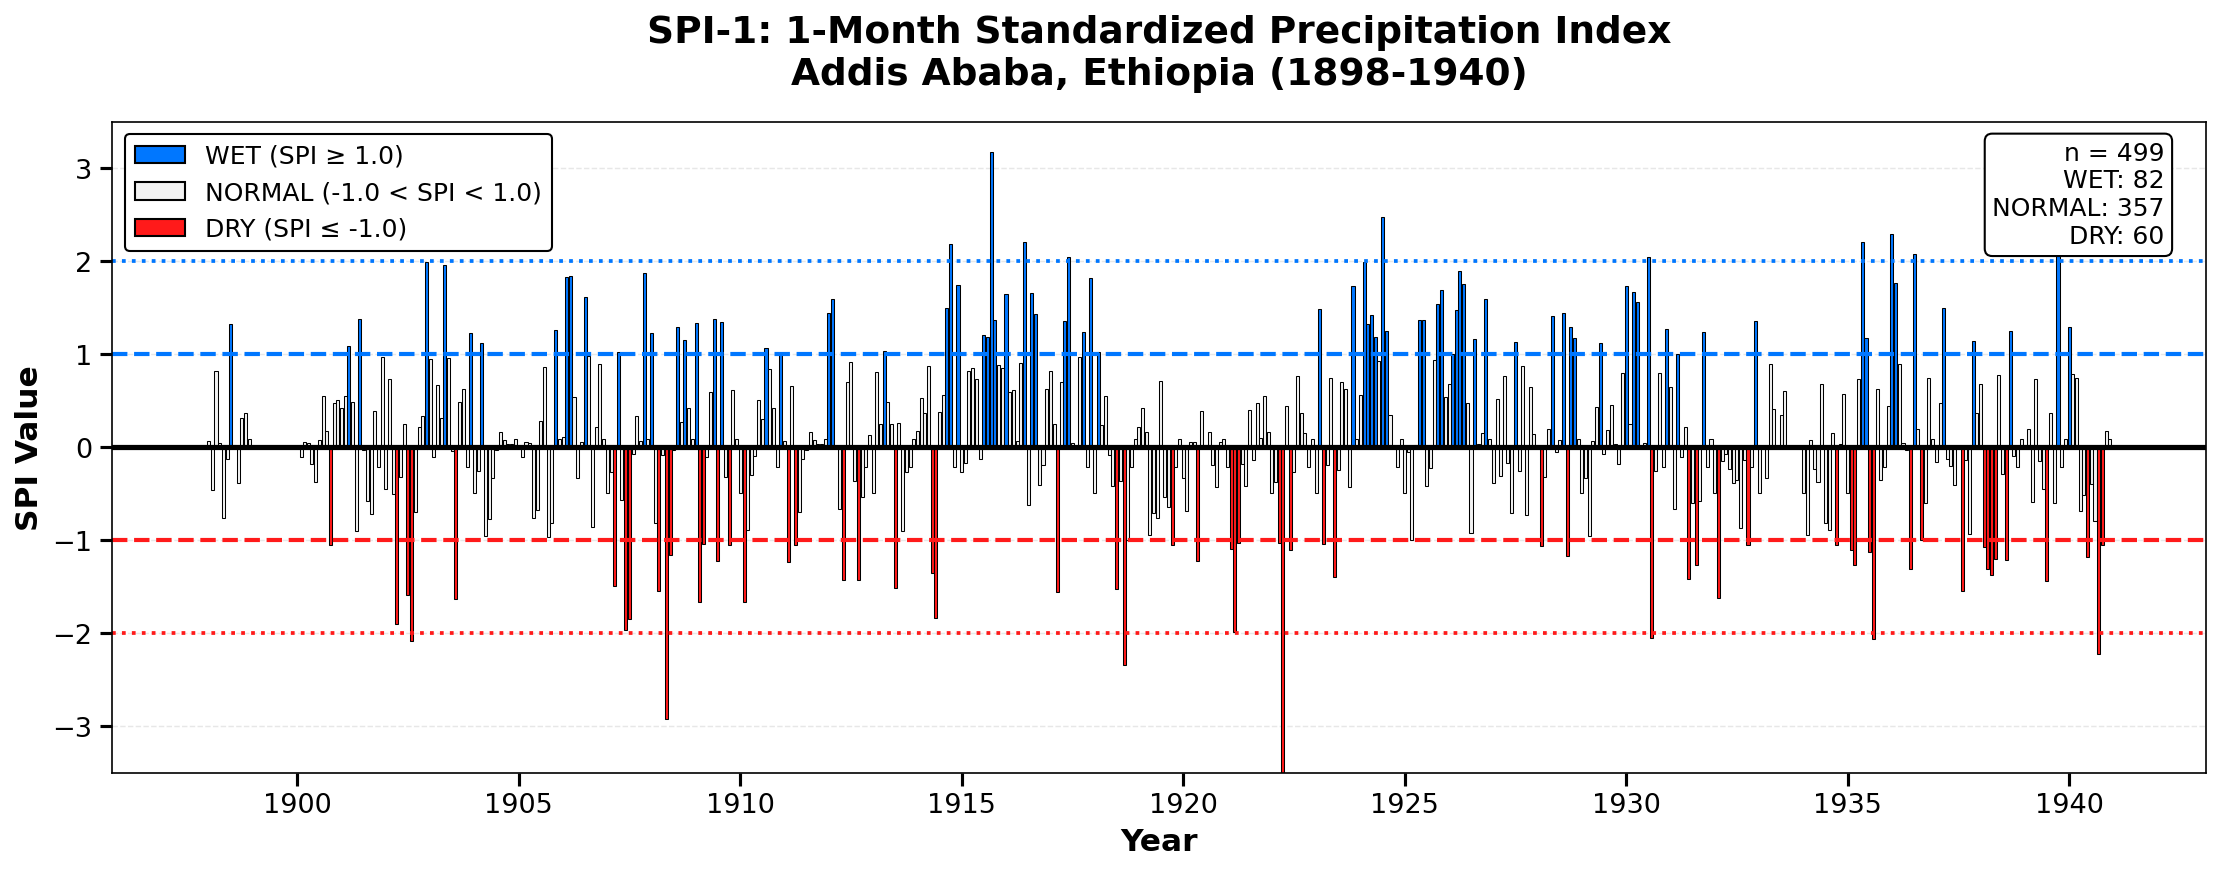

Created: SPI3_TimeSeries.png


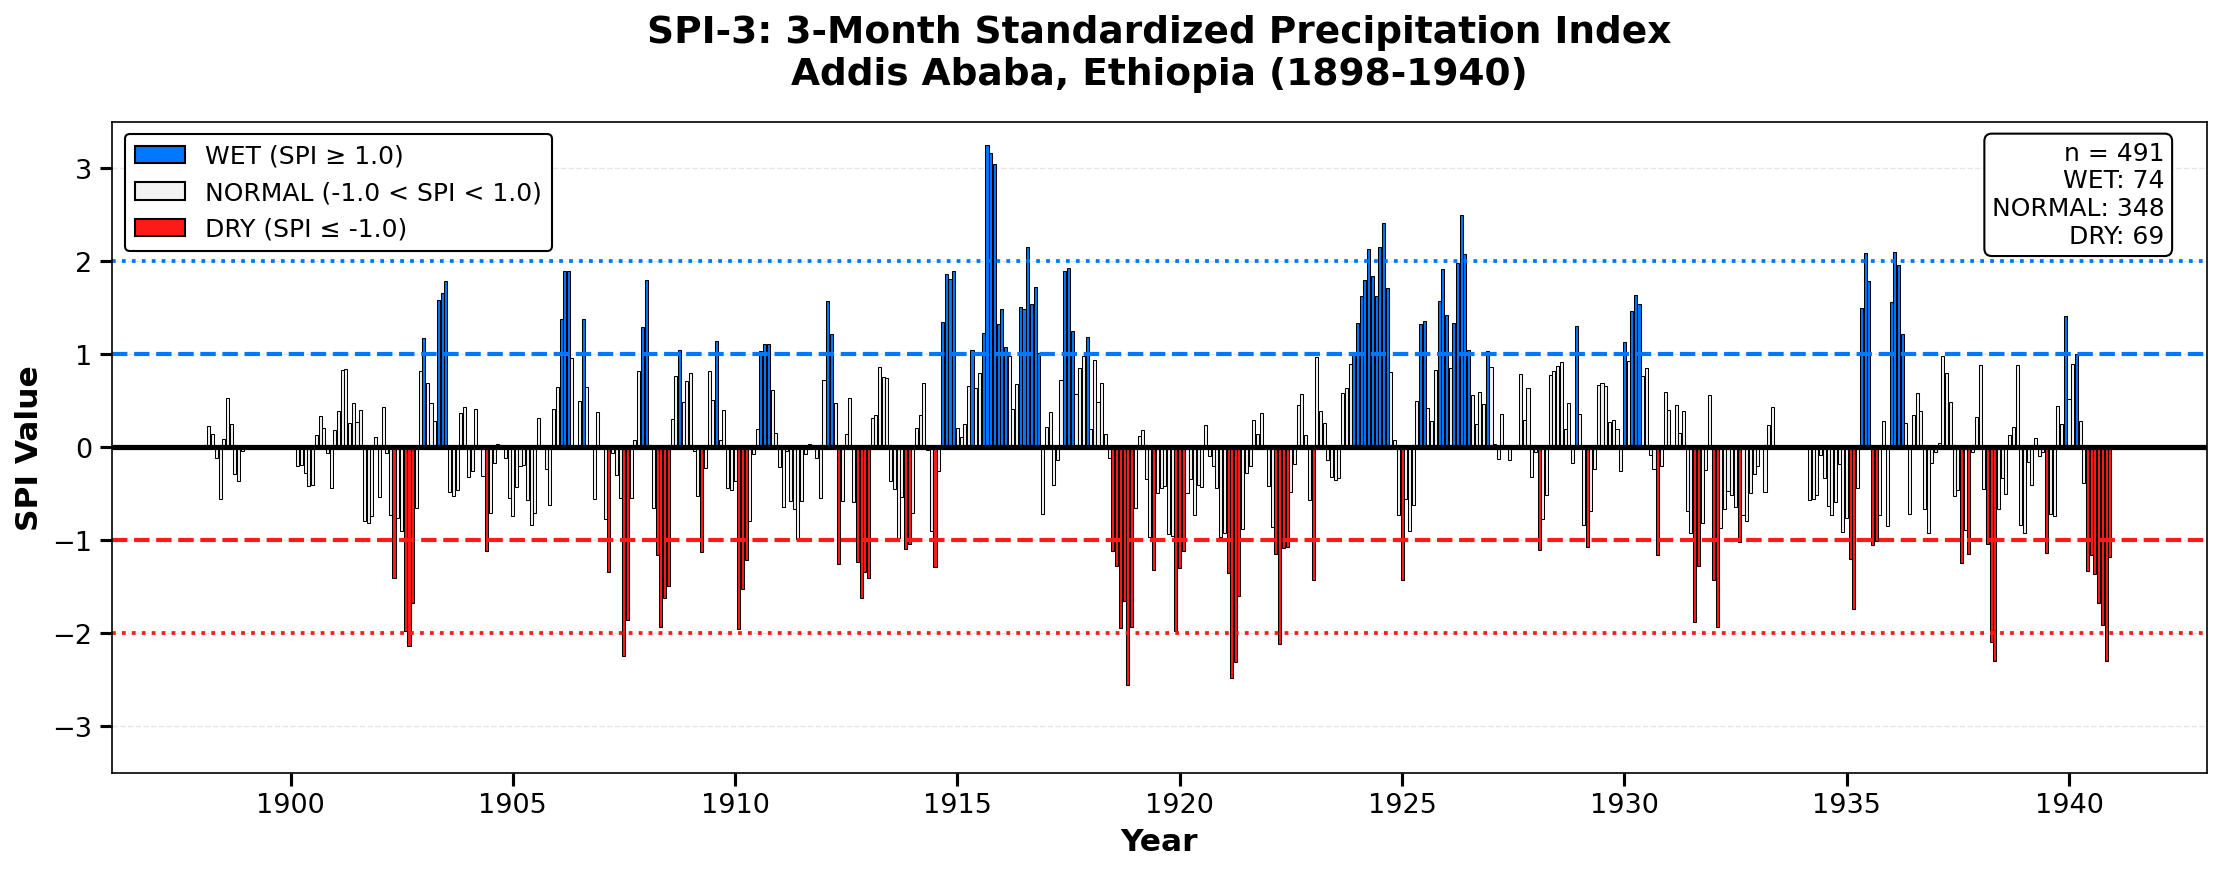

Created: SPI6_TimeSeries.png


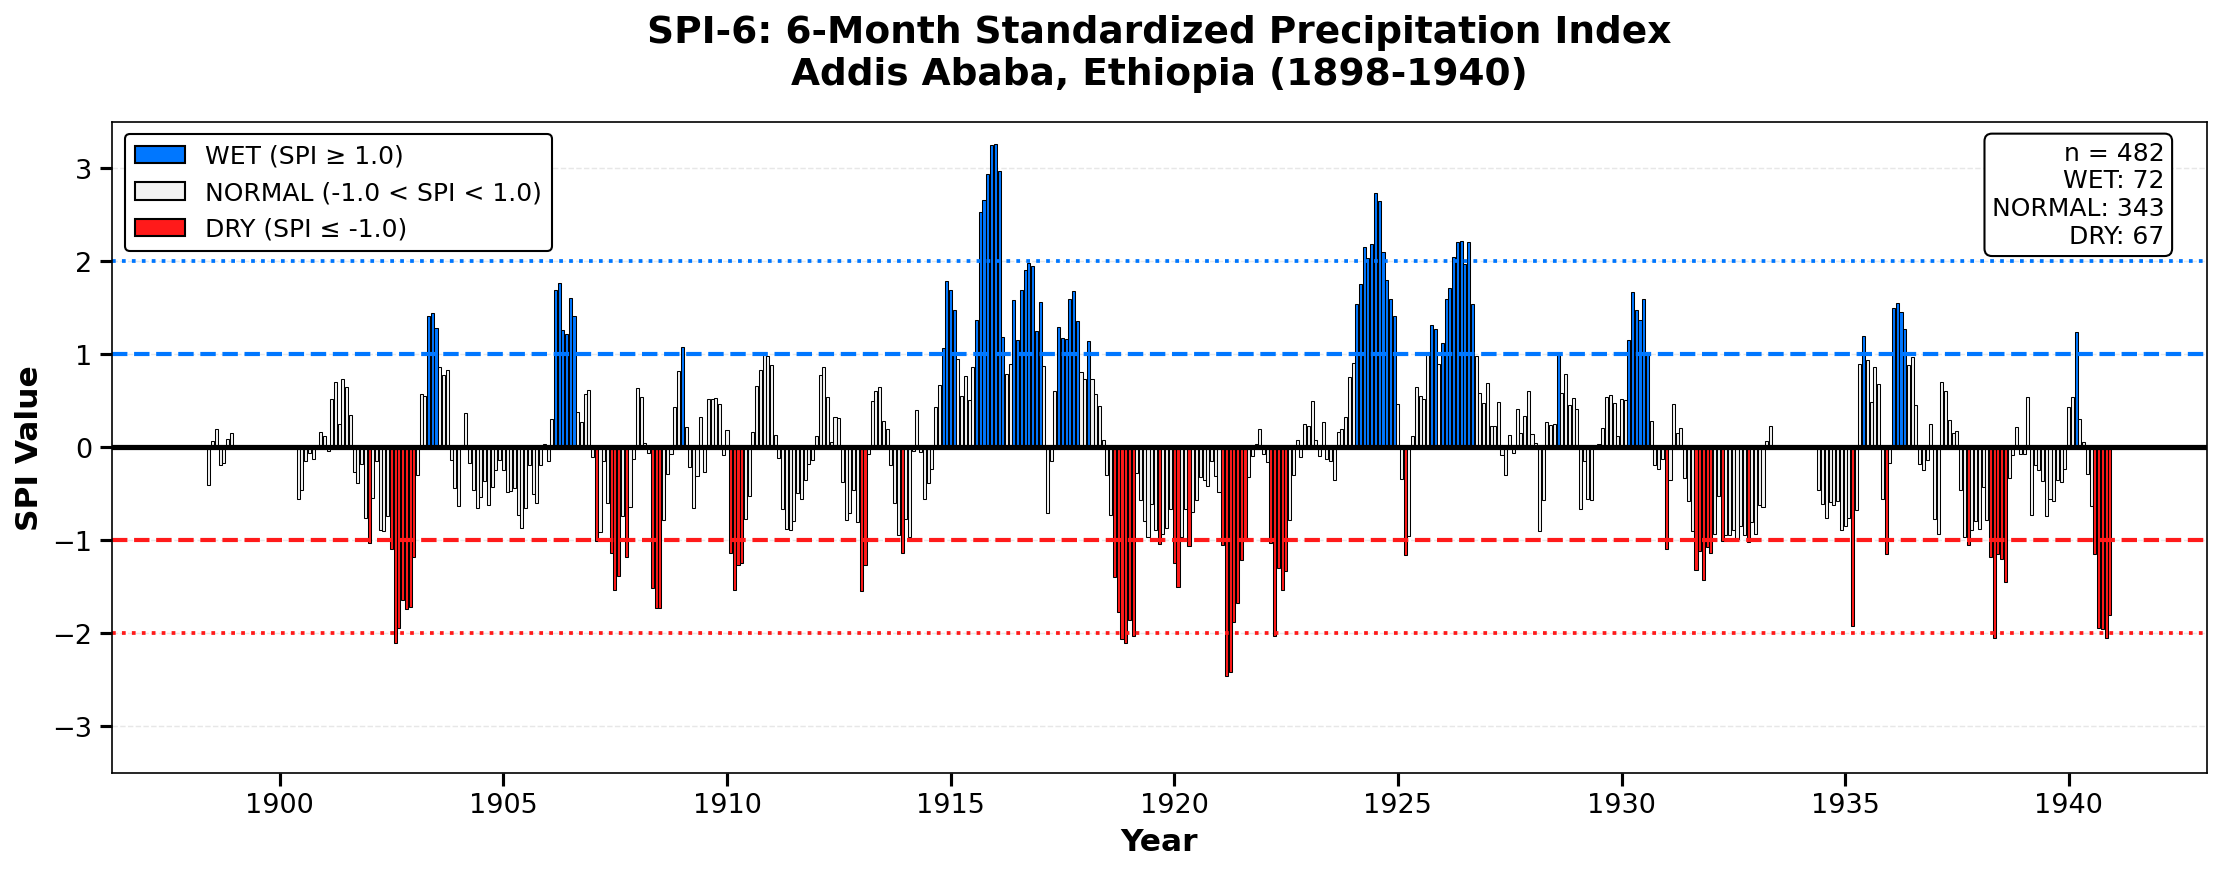

Created: SPI12_TimeSeries.png


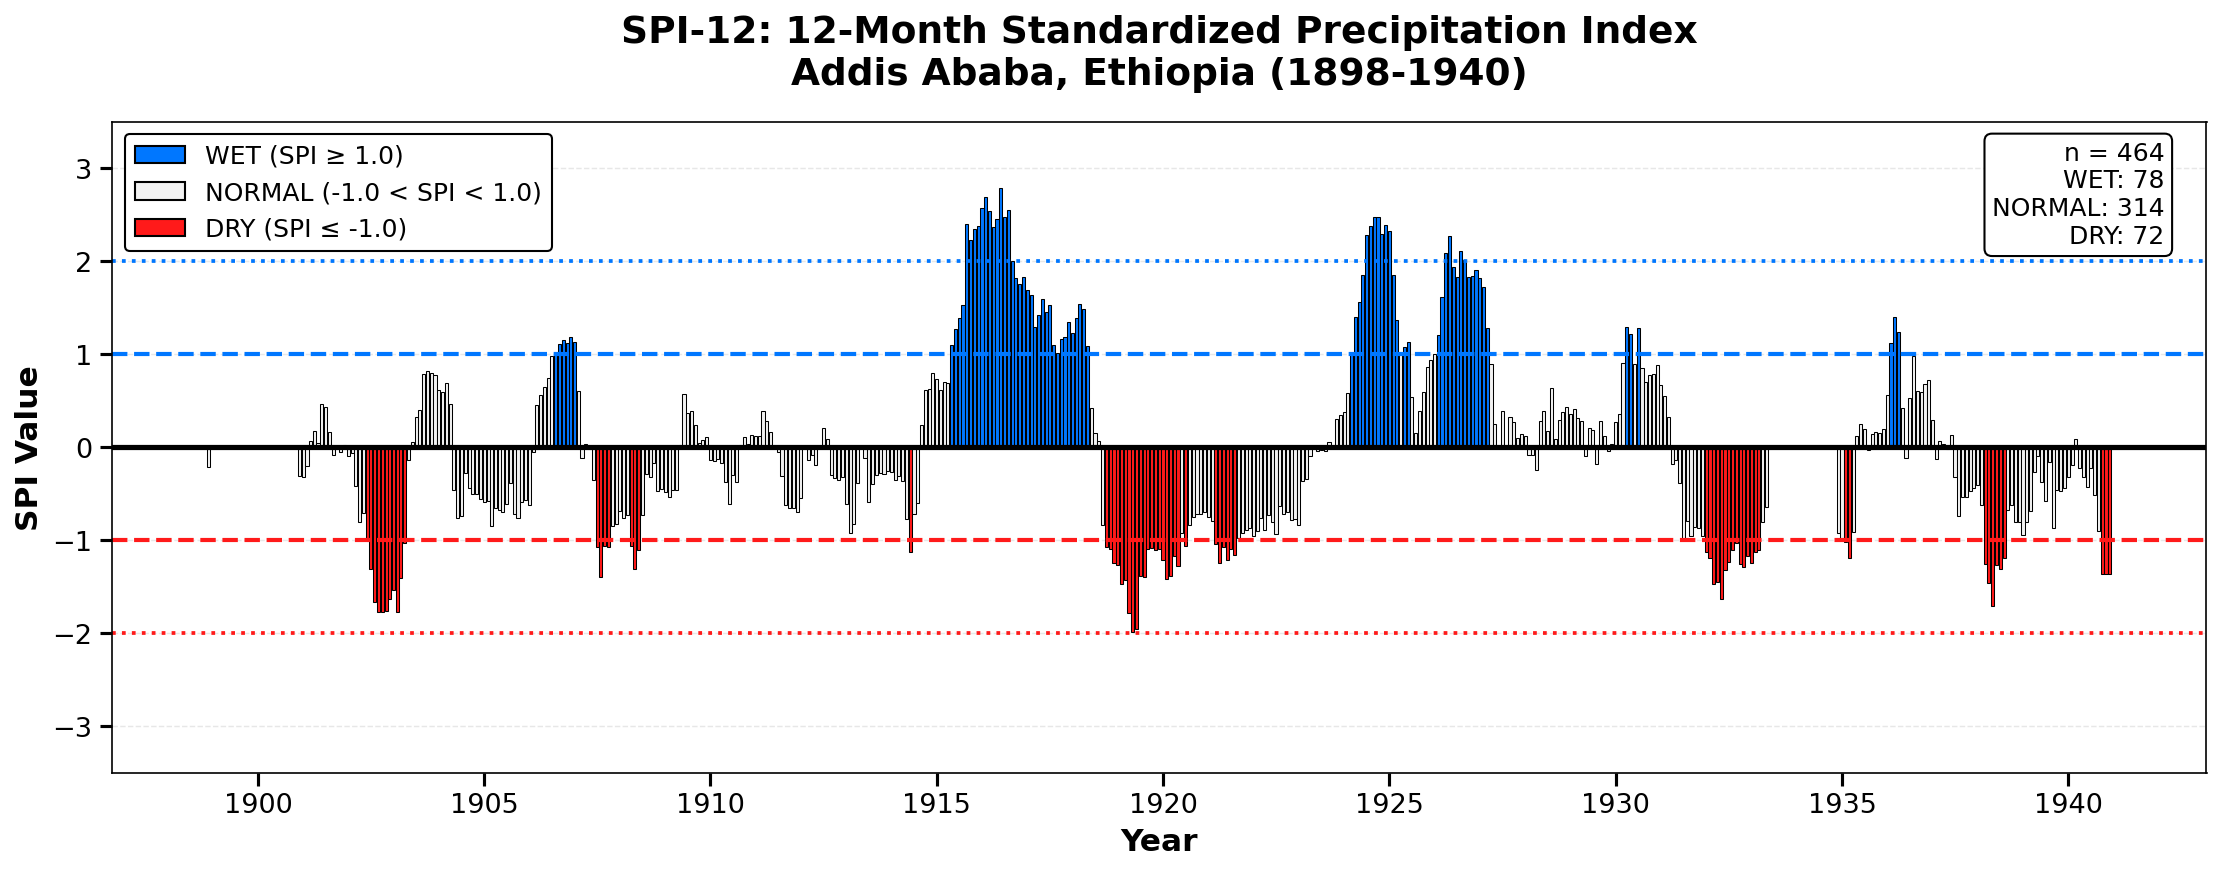


All visualizations created successfully.


In [ ]:
# ============================================================================
# CELL 5: CREATE VISUALIZATIONS (BRIGHT HIGH-CONTRAST VERSION)
# ============================================================================

print("\n" + "="*80)
print("STEP 4: CREATING VISUALIZATIONS")
print("="*80)

# Strong, presentation-visible fonts
plt.rcParams['figure.dpi'] = 150
plt.rcParams['font.size'] = 13
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['xtick.labelsize'] = 13
plt.rcParams['ytick.labelsize'] = 13
plt.rcParams['legend.fontsize'] = 12

# VERY BRIGHT HIGH-CONTRAST COLORS
COLOR_WET = '#0077FF'      # Bright vivid blue
COLOR_NORMAL = '#F2F2F2'   # Very light gray
COLOR_DRY = '#FF1A1A'      # Bright vivid red
COLOR_MISSING = '#BDBDBD'  # Medium gray

def assign_color(spi_value):
    if pd.isna(spi_value):
        return COLOR_MISSING
    elif spi_value >= 1.0:
        return COLOR_WET
    elif spi_value <= -1.0:
        return COLOR_DRY
    else:
        return COLOR_NORMAL


print("\nCreating plots...")

for scale in timescales:
    spi_col = f'SPI_{scale}'
    plot_data = df_long[['Date', spi_col]].dropna().copy()

    fig, ax = plt.subplots(figsize=(15, 6))

    colors = [assign_color(val) for val in plot_data[spi_col]]

    # FULL OPACITY bars
    ax.bar(plot_data['Date'], plot_data[spi_col],
           width=25,
           color=colors,
           edgecolor='black',
           linewidth=0.5,
           alpha=1.0)

    # Strong reference lines
    ax.axhline(0, color='black', linewidth=2.5)

    ax.axhline(1.0, color=COLOR_WET, linewidth=2, linestyle='--')
    ax.axhline(-1.0, color=COLOR_DRY, linewidth=2, linestyle='--')

    ax.axhline(2.0, color=COLOR_WET, linewidth=1.8, linestyle=':')
    ax.axhline(-2.0, color=COLOR_DRY, linewidth=1.8, linestyle=':')

    ax.set_title(f'SPI-{scale}: {scale}-Month Standardized Precipitation Index\n'
                 'Addis Ababa, Ethiopia (1898-1940)',
                 fontweight='bold',
                 pad=18)

    ax.set_xlabel('Year', fontweight='bold')
    ax.set_ylabel('SPI Value', fontweight='bold')

    ax.set_ylim(-3.5, 3.5)
    ax.set_yticks([-3, -2, -1, 0, 1, 2, 3])

    ax.xaxis.set_major_locator(mdates.YearLocator(5))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

    ax.tick_params(axis='both', which='major', width=1.5, length=6)

    # Only horizontal grid
    ax.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.3)
    ax.set_axisbelow(True)

    legend_elements = [
        Patch(facecolor=COLOR_WET, edgecolor='black', label='WET (SPI ≥ 1.0)'),
        Patch(facecolor=COLOR_NORMAL, edgecolor='black', label='NORMAL (-1.0 < SPI < 1.0)'),
        Patch(facecolor=COLOR_DRY, edgecolor='black', label='DRY (SPI ≤ -1.0)')
    ]

    ax.legend(handles=legend_elements,
              loc='upper left',
              frameon=True,
              facecolor='white',
              edgecolor='black',
              framealpha=1)

    # Statistics box
    data_vals = plot_data[spi_col]
    n_wet = (data_vals >= 1.0).sum()
    n_normal = ((data_vals > -1.0) & (data_vals < 1.0)).sum()
    n_dry = (data_vals <= -1.0).sum()

    stats_text = f"n = {len(data_vals)}\nWET: {n_wet}\nNORMAL: {n_normal}\nDRY: {n_dry}"

    ax.text(0.98, 0.97, stats_text,
            transform=ax.transAxes,
            fontsize=12,
            verticalalignment='top',
            horizontalalignment='right',
            bbox=dict(boxstyle='round',
                      facecolor='white',
                      edgecolor='black',
                      alpha=1))

    plt.tight_layout()

    output_filename = f'SPI{scale}_TimeSeries.png'
    plt.savefig(output_filename, dpi=300, bbox_inches='tight')
    print(f"Created: {output_filename}")

    plt.show()
    plt.close()

print("\nAll visualizations created successfully.")


In [ ]:
print("\n" + "="*80)
print("STEP 5: SAVING RESULTS")
print("="*80)

# Save SPI results to CSV
output_csv = 'SPI_Results_Complete.csv'
df_long.to_csv(output_csv, index=False)
print(f"✓ Saved: {output_csv}")

# Create verification statistics
verification_data = []
for scale in timescales:
    spi_col = f'SPI_{scale}'
    spi_data = df_long[spi_col].dropna()

    ks_stat, ks_pval = stats.kstest(spi_data, 'norm')

    verification_data.append({
        'Timescale': f'SPI-{scale}',
        'N_values': len(spi_data),
        'Mean': spi_data.mean(),
        'StdDev': spi_data.std(),
        'Skewness': stats.skew(spi_data),
        'Kurtosis': stats.kurtosis(spi_data),
        'KS_statistic': ks_stat,
        'KS_pvalue': ks_pval
    })

verification_df = pd.DataFrame(verification_data)
verification_csv = 'SPI_Verification_Statistics.csv'
verification_df.to_csv(verification_csv, index=False)
print(f"✓ Saved: {verification_csv}")

print("\nVerification Statistics:")
print(verification_df.to_string(index=False))



STEP 5: SAVING RESULTS
✓ Saved: SPI_Results_Complete.csv
✓ Saved: SPI_Verification_Statistics.csv

Verification Statistics:
Timescale  N_values      Mean   StdDev  Skewness  Kurtosis  KS_statistic  KS_pvalue
    SPI-1       499  0.089636 0.921118 -0.067569  0.571527      0.095826   0.000194
    SPI-3       491  0.008316 0.986651  0.194338  0.119866      0.028964   0.793362
    SPI-6       482 -0.000713 1.000965  0.393009  0.229271      0.053309   0.124593
   SPI-12       464 -0.000718 1.001027  0.643947 -0.057620      0.074746   0.010616


In [ ]:
print("\n" + "="*80)
print("STEP 6: DOWNLOAD YOUR RESULTS")
print("="*80)
print("\nDownloading all generated files...")
print("(Check your browser's download folder)")

# Download CSV files
files.download(output_csv)
files.download(verification_csv)

# Download plot images
for scale in timescales:
    filename = f'SPI{scale}_TimeSeries.png'
    files.download(filename)

print("\n✓ All files downloaded!")
print("\n" + "="*80)
print("ANALYSIS COMPLETE!")
print("="*80)
print("\nYou should now have:")
print("  - SPI_Results_Complete.csv (all calculated SPI values)")
print("  - SPI_Verification_Statistics.csv (statistical verification)")
print("  - 4 PNG files (SPI time series plots)")
print("\nThank you for using this script!")



STEP 6: DOWNLOAD YOUR RESULTS

(Check your browser's download folder)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


✓ All files downloaded!

ANALYSIS COMPLETE!

You should now have:
  - SPI_Results_Complete.csv (all calculated SPI values)
  - SPI_Verification_Statistics.csv (statistical verification)
  - 4 PNG files (SPI time series plots)

Thank you for using this script!
